# BWR Micro Core

**Inputs** 

- `PSZ`: Fuel bundle region Power Shaping Zone (PSZ).
- `DOM`:  Fuel bundle region Dominant zone (DOM).
- `vanA`: Fuel bundle region vanishing zone A (VANA).
- `vanB`: Fuel bundle region vanishing zone B (VANB)
- `subcool`: Represents moderator inlet conditions. Core inlet subcooling is interpreted as at the steam dome pressure (i.e., not core-averaged pressure). The input value for subcooling will automatically be increased to account for this fact. (Btu/lb)?
- `CRD`: Defines the position of all control rod groups (banks).
- `flow_rate`: Defines essential global design data for rated coolant mass flux for the active core, $\frac{kg}{(cm^{2}-hr)}$. Coolant   mass flux equals active core flow divided by core cross-section area. The core cross-section area is DXA 2 times the number of assemblies.
- `power_density`: Defines essential global design data for rated power density using cold dimensions, $(\frac{kw}{liter})$.
- `VFNGAP`: Defines the narrow water gap width ratio to the sum of the narrow and wide water gap widths.

**Output**

- `K-eff`:  Reactivity coefficient k-effective, the effective neutron multiplication factor.
- `Max3Pin`: Maximum planar-averaged pin power peaking factor.
- `Max4Pin`: maximum pin-power peaking factor, $F_{q}$, (which includes axial intranodal peaking).
- `F-delta-H`: Ratio of max-to-average enthalpy rises in a channel.
- `Max-Fxy`: Maximum radial pin-power peaking factor.

The data set consists of 2000 data points with nine inputs and five outputs. This data set was constructed through uniform and normal sampling of the 9 input parameters for a boiling water reactor (BWR) micro-core. These samples were then used to solve for reactor characteristic changes in heat distribution and neutron flux. This BWR micro-core consists of 4 radially and axially heterogeneous assemblies of the same type constructed in a 2x2 grid with a control blade placed in the center. A single assembly composition can be seen in the figure below. A single assembly was broken into seven zones where each zone's 2D radial cross-sectional information was constructed using CASMO-4. These cross sectional libraries were then processed through CMSLINK for SIMULATE-3 to interpret. The core geometry and physics were implemented and modeled using SIMULATE-3 [[RFS21]](https://pymaise.readthedocs.io/en/stable/index.html#id3).
    
Note: The reference uses the same model as this example, but the data generated differs from the paper.

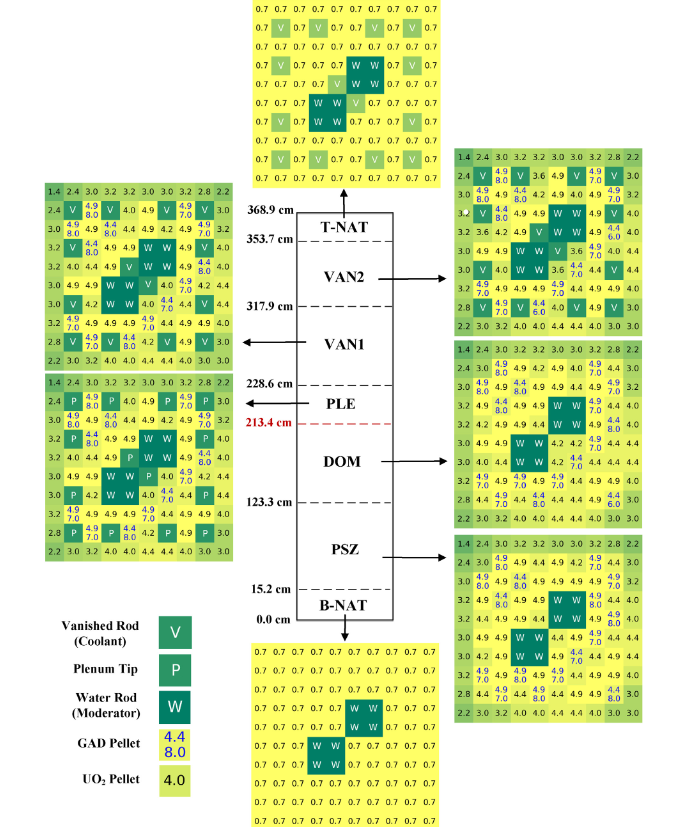

To start, we import all the needed packages.

In [1]:
from pyMAISE.datasets import load_BWR
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We initialize pyMAISE as a regression problem and load the BWR data set.

In [2]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_BWR()

The BWR micro reactor data set has 9 inputs:

In [3]:
inputs

<xarray.DataArray (index: 2000, variable: 9)>
array([[1.20334e+02, 2.16336e+02, 3.38763e+02, ..., 2.50161e+02,
        6.62500e+01, 2.22000e-01],
       [1.37906e+02, 1.98764e+02, 3.49531e+02, ..., 2.53792e+02,
        6.60440e+01, 3.93000e-01],
       [1.31235e+02, 2.05435e+02, 3.17283e+02, ..., 2.55631e+02,
        6.58390e+01, 4.32000e-01],
       ...,
       [1.11014e+02, 2.25656e+02, 3.04242e+02, ..., 2.47461e+02,
        6.27380e+01, 3.46000e-01],
       [1.10651e+02, 2.26019e+02, 3.11476e+02, ..., 2.54682e+02,
        6.57490e+01, 3.55000e-01],
       [1.17517e+02, 2.19153e+02, 3.46947e+02, ..., 2.50026e+02,
        6.54060e+01, 2.35000e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'PSZ' 'DOM' 'vanA' ... 'power_density' 'VFNGAP'

and 5 outputs with 2000 samples:

In [4]:
outputs

<xarray.DataArray (index: 2000, variable: 5)>
array([[0.95455, 5.105  , 5.303  , 1.861  , 1.899  ],
       [0.98576, 2.839  , 2.904  , 1.436  , 1.816  ],
       [0.95237, 5.161  , 5.43   , 1.846  , 1.903  ],
       ...,
       [0.99524, 2.471  , 2.54   , 1.261  , 1.842  ],
       [0.70601, 7.199  , 7.752  , 1.51   , 1.854  ],
       [0.99079, 2.507  , 2.595  , 1.326  , 1.831  ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'K-eff' 'Max3Pin' ... 'F-delta-H' 'Max-Fxy'

To better understand the data here is a correlation matrix of the data.

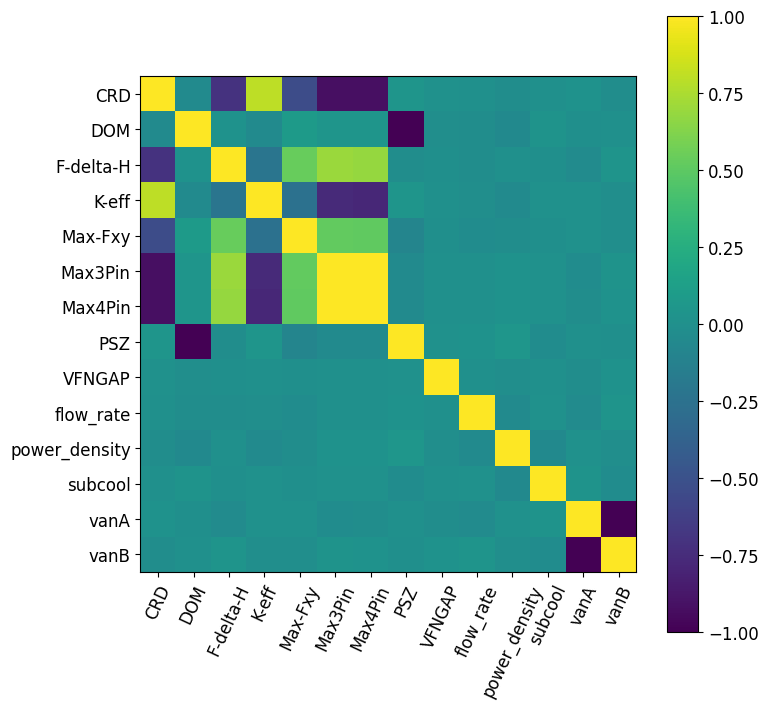

In [5]:
correlation_matrix(data)
plt.show()

As expected, a strong negative correlation exists between the control rod position (CRD) and the peaking factors. A strong positive correlation exists between control rod position and k effective.

Prior to model training, the data is min-max scaled to make each feature's effect size comparable. Additionally, this can improve the performance of some models.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

Given this data set has a multi-dimensional output we will compare the performance of 6 machine learning (ML) models:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayers, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=5),
                "units": mai.Int(min_value=25, max_value=600),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32, 64]),
            "epochs": 100,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

We use a random search with 200 iterations and 5 cross-validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN, we use Bayesian search with 150 iterations and 5 cross-validation splits (750 fits total). This offers possible convergence on an optimal configuration without taking excessive time. Classical models tend to be simpler than neural networks, so many random search iterations are possible.

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=150,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 305.1060548901558 minutes to process.


Below is the convergence plot for the FNN Bayesian search.

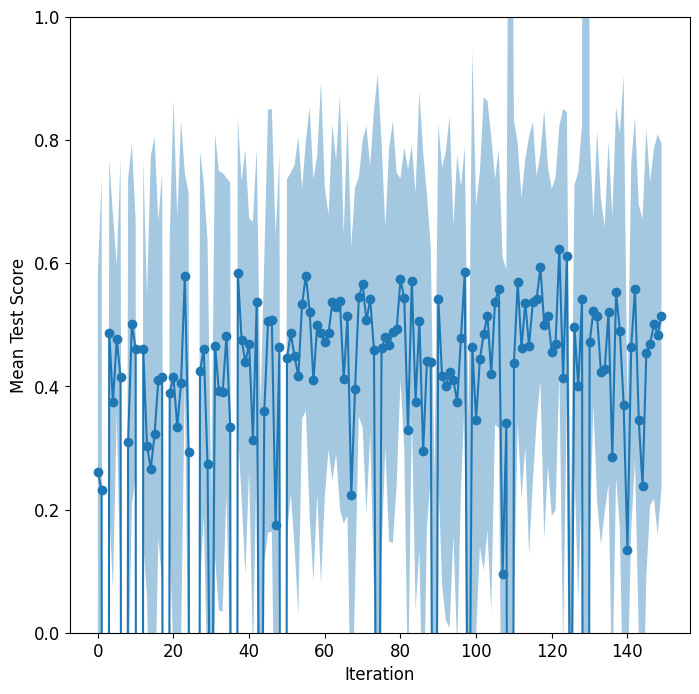

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

The search could not produce an FNN configuration with performance better than ~0.55 validation $R^2$.

## Model Post-processing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. We will increase the `FNN' models 'epochs' for better performance.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 500}},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we will compute five metrics for both the training and testing data: 

- mean absolute percentage error: `MAPE` $=\frac{100}{n} \sum_{i = 1}^n \frac{|y_i - \hat{y}_i|}{\text{max}(\epsilon, |y_i|)}$,
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y}_i)^2}$,
- root mean squared percentage error `RMSPE` $= \sqrt{\frac{1}{n}\sum_{i = 1}^n\Big(\frac{y_i - \hat{y}_i}{\text{max}(\epsilon, |y_i|)}\Big)^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y}_i|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y}_i)^2}{\sum^n_{i = 1}(y_i - \bar{y}_i)^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The performance metrics for each model are evaluated below for each output starting with `K-eff`.

In [11]:
postprocessor.metrics(y="K-eff").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
25,FNN,0.998303,0.001424,0.169349,0.003637,0.455390,0.996405,0.002388,0.291216,0.005397,0.689291
11,RF,0.998435,0.001695,0.196271,0.003492,0.436263,0.992740,0.003271,0.386216,0.007669,0.961833
7,DT,0.995810,0.002660,0.307332,0.005715,0.689514,0.992295,0.003575,0.414740,0.007900,0.954859
6,DT,0.995882,0.002618,0.302728,0.005665,0.683956,0.992259,0.003576,0.414907,0.007919,0.956924
8,DT,0.995630,0.002761,0.318694,0.005836,0.703046,0.992155,0.003590,0.416194,0.007972,0.961779
14,RF,0.997269,0.002412,0.283091,0.004614,0.577134,0.991274,0.003916,0.467709,0.008408,1.066698
12,RF,0.995857,0.002773,0.325478,0.005682,0.714894,0.991212,0.003722,0.444031,0.008437,1.073514
22,FNN,0.998166,0.002121,0.242785,0.003781,0.458634,0.991166,0.003506,0.418346,0.008460,1.090126
21,FNN,0.997350,0.002842,0.311729,0.004545,0.536183,0.990622,0.004519,0.523973,0.008716,1.095897
10,DT,0.995512,0.002825,0.326936,0.005915,0.715577,0.990333,0.003811,0.442185,0.008849,1.066137


In [12]:
postprocessor.metrics(y="Max3Pin").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
11,RF,0.995726,0.044176,0.928623,0.102578,2.323391,0.984957,0.087188,1.791144,0.196767,3.962628
6,DT,0.988681,0.075067,1.624548,0.166926,3.661493,0.981891,0.097590,2.065677,0.215890,4.121946
7,DT,0.988542,0.076861,1.666638,0.167944,3.683252,0.981852,0.098736,2.092037,0.216122,4.129966
8,DT,0.988191,0.079194,1.715242,0.170495,3.725483,0.981832,0.099104,2.102479,0.216246,4.135272
10,DT,0.987146,0.082374,1.776702,0.177885,3.830962,0.980811,0.101625,2.140302,0.222235,4.170010
12,RF,0.987362,0.081947,1.791495,0.176382,4.048259,0.979239,0.107201,2.312303,0.231163,4.838359
14,RF,0.990793,0.069062,1.467048,0.150548,3.471764,0.976923,0.116082,2.439219,0.243714,5.229085
15,RF,0.984234,0.092291,2.006246,0.197002,4.521244,0.976087,0.116304,2.513173,0.248090,5.238551
13,RF,0.983410,0.092411,2.008918,0.202087,4.666160,0.974399,0.119520,2.572304,0.256695,5.421975
9,DT,1.000000,0.000000,0.000000,0.000000,0.000000,0.970393,0.115328,2.444655,0.276050,5.514115


In [13]:
postprocessor.metrics(y="Max4Pin").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
11,RF,0.995927,0.046586,0.935086,0.107796,2.209980,0.985891,0.088710,1.743152,0.205498,3.978844
6,DT,0.990382,0.074682,1.560499,0.165657,3.374714,0.984477,0.097881,2.006133,0.215548,4.003204
7,DT,0.990250,0.076187,1.596367,0.166786,3.397349,0.984442,0.098796,2.027911,0.215792,4.011848
8,DT,0.989925,0.079510,1.661843,0.169545,3.442838,0.984431,0.099019,2.033118,0.215869,4.014841
10,DT,0.988851,0.081736,1.703356,0.178355,3.591827,0.983605,0.101285,2.069851,0.221518,4.021953
12,RF,0.987985,0.084972,1.782446,0.185148,3.931994,0.980046,0.110448,2.295183,0.244383,4.929675
14,RF,0.991127,0.072269,1.475772,0.159110,3.435016,0.977648,0.120137,2.427925,0.258656,5.371998
15,RF,0.985268,0.095147,1.987318,0.205019,4.376875,0.977538,0.118990,2.480990,0.259289,5.298902
9,DT,1.000000,0.000000,0.000000,0.000000,0.000000,0.976713,0.111960,2.289270,0.264006,5.046045
13,RF,0.984484,0.095529,1.999539,0.210404,4.535707,0.975753,0.122513,2.546836,0.269396,5.509878


In [14]:
postprocessor.metrics(y="F-delta-H").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
22,FNN,0.995914,0.007308,0.458624,0.012875,0.780985,0.987904,0.012308,0.765635,0.022506,1.358494
11,RF,0.996798,0.006687,0.412891,0.011397,0.683707,0.987475,0.012935,0.799305,0.022902,1.378841
25,FNN,0.993607,0.010933,0.694136,0.016106,0.996267,0.985565,0.015866,0.991894,0.024586,1.485557
12,RF,0.992502,0.010850,0.671277,0.017442,1.045151,0.985241,0.014465,0.893337,0.024860,1.483990
14,RF,0.994912,0.008936,0.551004,0.014368,0.857889,0.984739,0.014644,0.897960,0.025280,1.487334
13,RF,0.991276,0.011853,0.734908,0.018814,1.128739,0.984114,0.015163,0.938402,0.025792,1.531883
8,DT,0.990480,0.011479,0.713480,0.019653,1.169256,0.983567,0.014758,0.919495,0.026233,1.573052
6,DT,0.991877,0.010466,0.649761,0.018154,1.080392,0.983228,0.014528,0.903348,0.026502,1.586100
15,RF,0.990873,0.012205,0.756610,0.019244,1.154156,0.983207,0.015578,0.964806,0.026519,1.578678
10,DT,0.991693,0.010706,0.666757,0.018359,1.094884,0.983079,0.015123,0.944434,0.026619,1.599733


In [15]:
postprocessor.metrics(y="Max-Fxy").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
12,RF,0.962996,0.004899,0.263365,0.009836,0.510666,0.913985,0.006676,0.356167,0.015318,0.785251
14,RF,0.969133,0.004962,0.269281,0.008984,0.477021,0.905864,0.007759,0.417014,0.016024,0.831546
11,RF,0.984363,0.003311,0.177933,0.006394,0.332177,0.904461,0.006711,0.357371,0.016143,0.825519
15,RF,0.956432,0.005342,0.287122,0.010673,0.553158,0.902284,0.007063,0.376763,0.016326,0.835852
13,RF,0.957454,0.005218,0.280311,0.010547,0.547796,0.899655,0.007171,0.382439,0.016545,0.848061
7,DT,0.967524,0.004285,0.231103,0.009215,0.488254,0.830728,0.007415,0.394273,0.021488,1.106871
6,DT,0.967588,0.004298,0.231832,0.009206,0.487788,0.830716,0.007412,0.394112,0.021489,1.106902
8,DT,0.966937,0.004481,0.241770,0.009298,0.492884,0.830432,0.007504,0.399169,0.021507,1.107977
10,DT,0.963546,0.004680,0.252344,0.009763,0.517782,0.826674,0.007607,0.404494,0.021744,1.121277
9,DT,1.000000,0.000000,0.000000,0.000000,0.000000,0.775321,0.007987,0.425251,0.024756,1.297171


In [16]:
postprocessor.metrics().drop(
    ["Parameter Configurations", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE"], 
    axis=1,
)

,Model Types,Train R2,Train MAPE,Train RMSPE,Test R2,Test MAPE,Test RMSPE
11,RF,0.994250,0.530161,1.197103,0.971105,1.015438,2.221533
12,RF,0.985340,0.966812,2.050193,0.969945,1.260204,2.622158
14,RF,0.988647,0.809239,1.763765,0.967289,1.329965,2.797332
15,RF,0.982352,1.080584,2.277435,0.965761,1.363758,2.821236
13,RF,0.982270,1.078028,2.336266,0.964651,1.387090,2.898575
6,DT,0.986882,0.873874,1.857669,0.954514,1.156835,2.355015
8,DT,0.986233,0.930206,1.906701,0.954484,1.174091,2.358584
7,DT,0.986746,0.893494,1.871305,0.954440,1.171316,2.361556
10,DT,0.985349,0.945219,1.950206,0.952901,1.200253,2.395822
9,DT,1.000000,0.000000,0.000000,0.937520,1.294056,2.982673


Based on the performance metrics presented above, random forest and decision tree are the top-performing models. FNN did well on all but `Max-Fxy`. K-nearest neighbors overfit to each output. Linear and lasso regression failed to capture any of the outputs, indicating that this data set is nonlinear.

Next, the best-performing model hyperparameters are shown.

In [17]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.0007903188127977431

Model Type: DT
  max_depth: 41
  max_features: None
  min_samples_leaf: 3
  min_samples_split: 13

Model Type: RF
  criterion: poisson
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 4
  n_estimators: 124

Model Type: KN
  leaf_size: 27
  n_neighbors: 10
  p: 2
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 25
      sublayer: None
    Layer: Dense_hidden_1
      units: 339
      sublayer: Dropout_hidden
    Layer: Dense_hidden_1_sublayer_Dropout_hidden_0
      rate: 0.2
    Layer: Dense_hidden_2
      units: 600
      sublayer: None
    Layer: Dense_hidden_3
      units: 600
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0003592782612078543
    batch_size: 8



To visualize the performance of these models we can use the `pyMAISE.PostProcessor.diagonal_validation_plot` functions to produce diagonal validation plots.

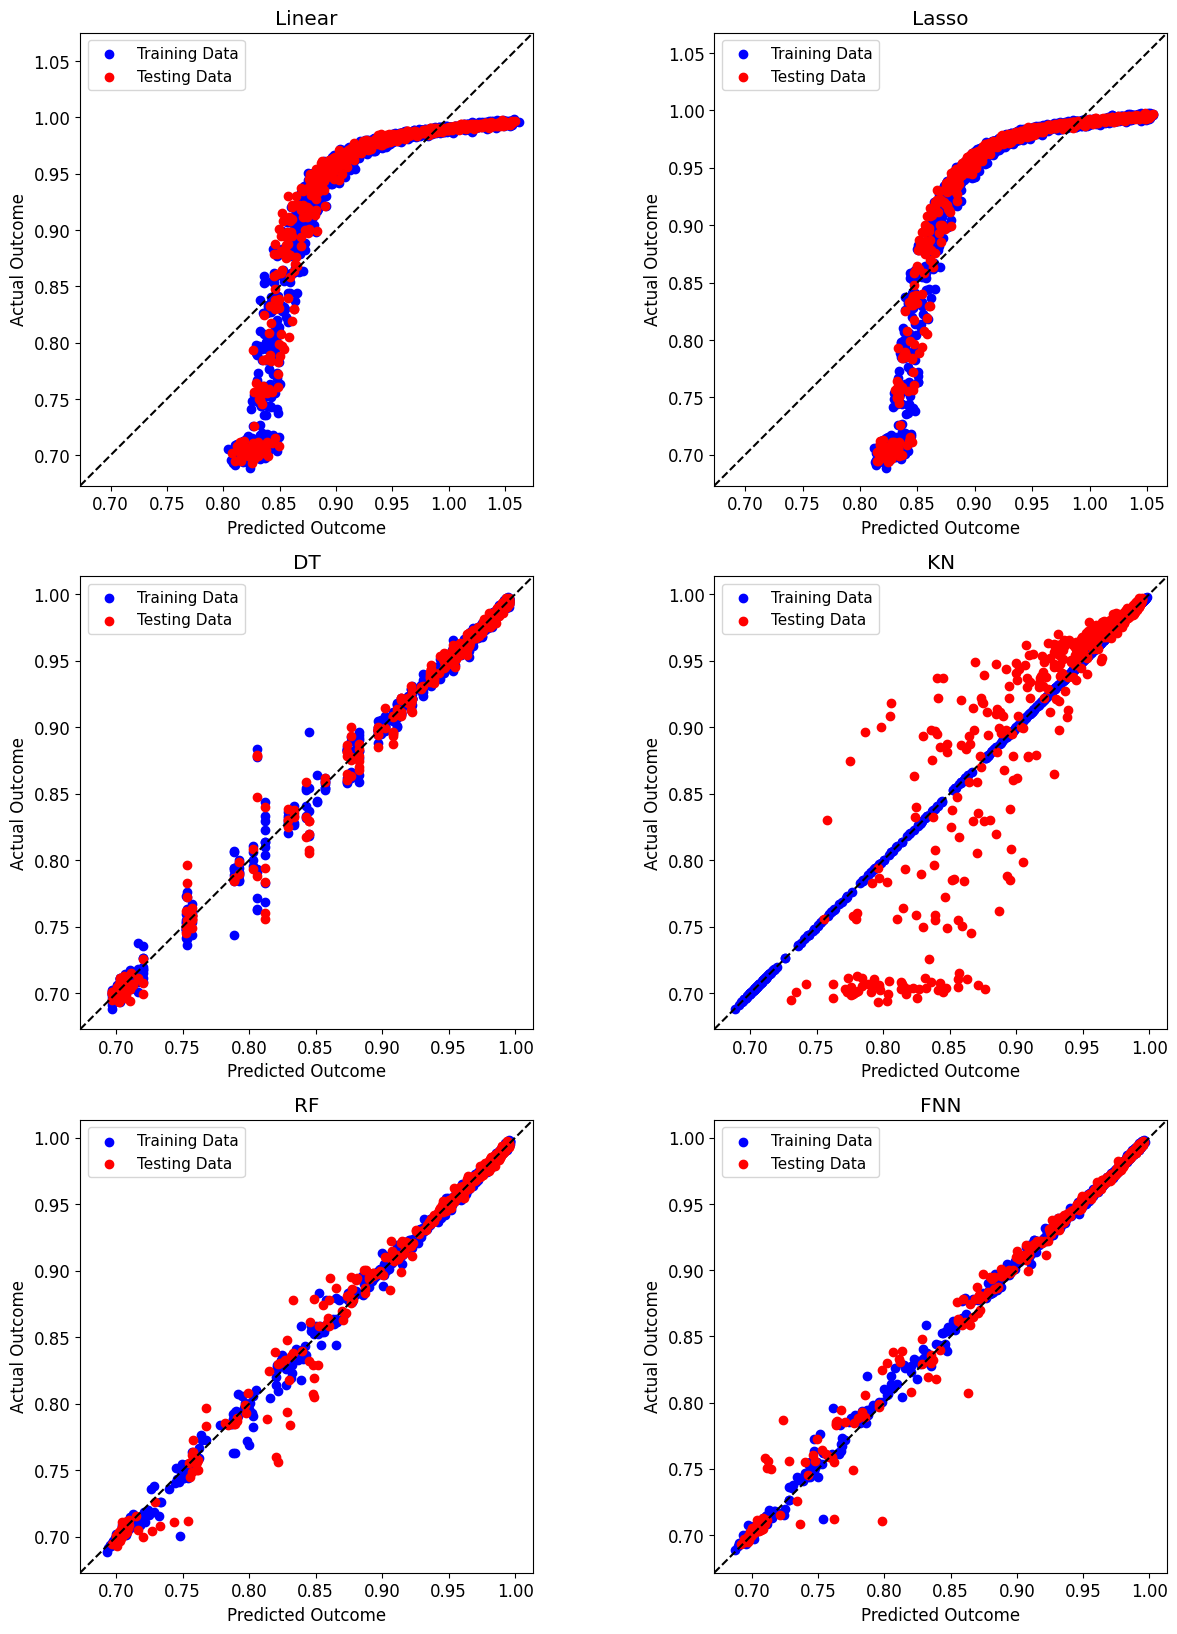

In [18]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])

performance_plot(postprocessor.diagonal_validation_plot, "K-eff")
plt.show()

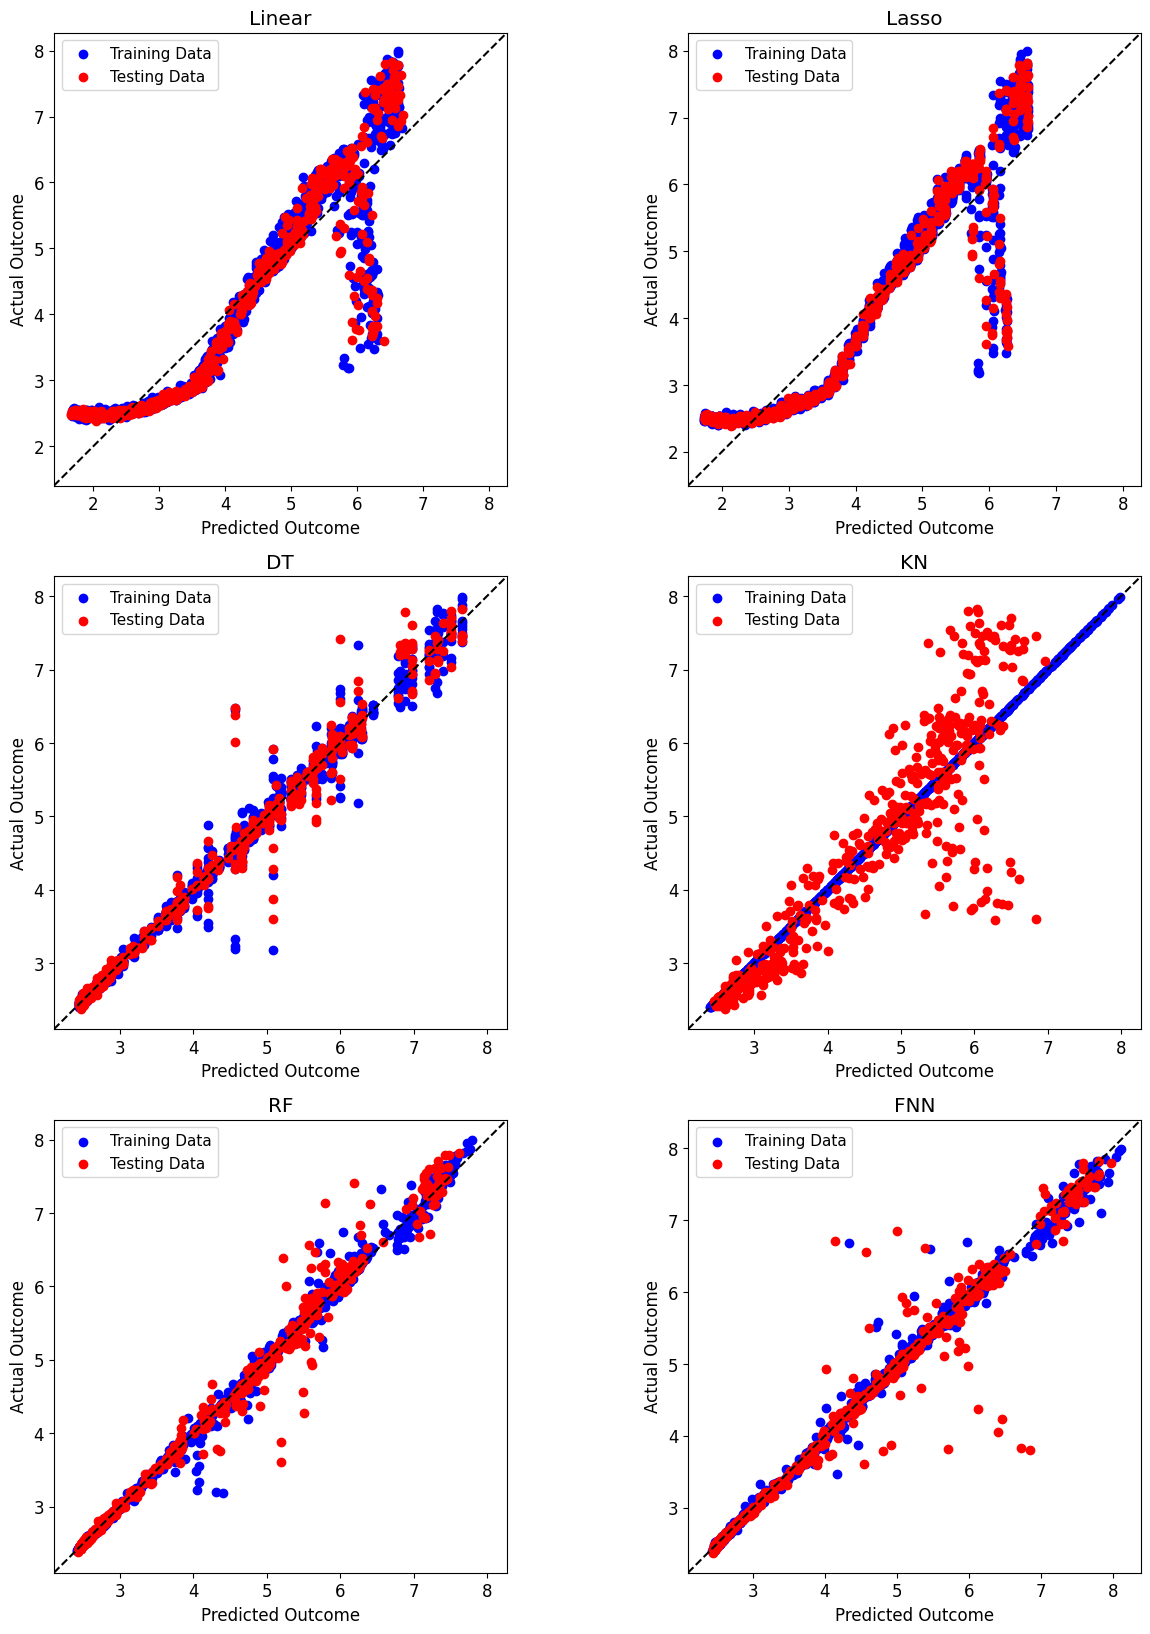

In [19]:
performance_plot(postprocessor.diagonal_validation_plot, "Max3Pin")
plt.show()

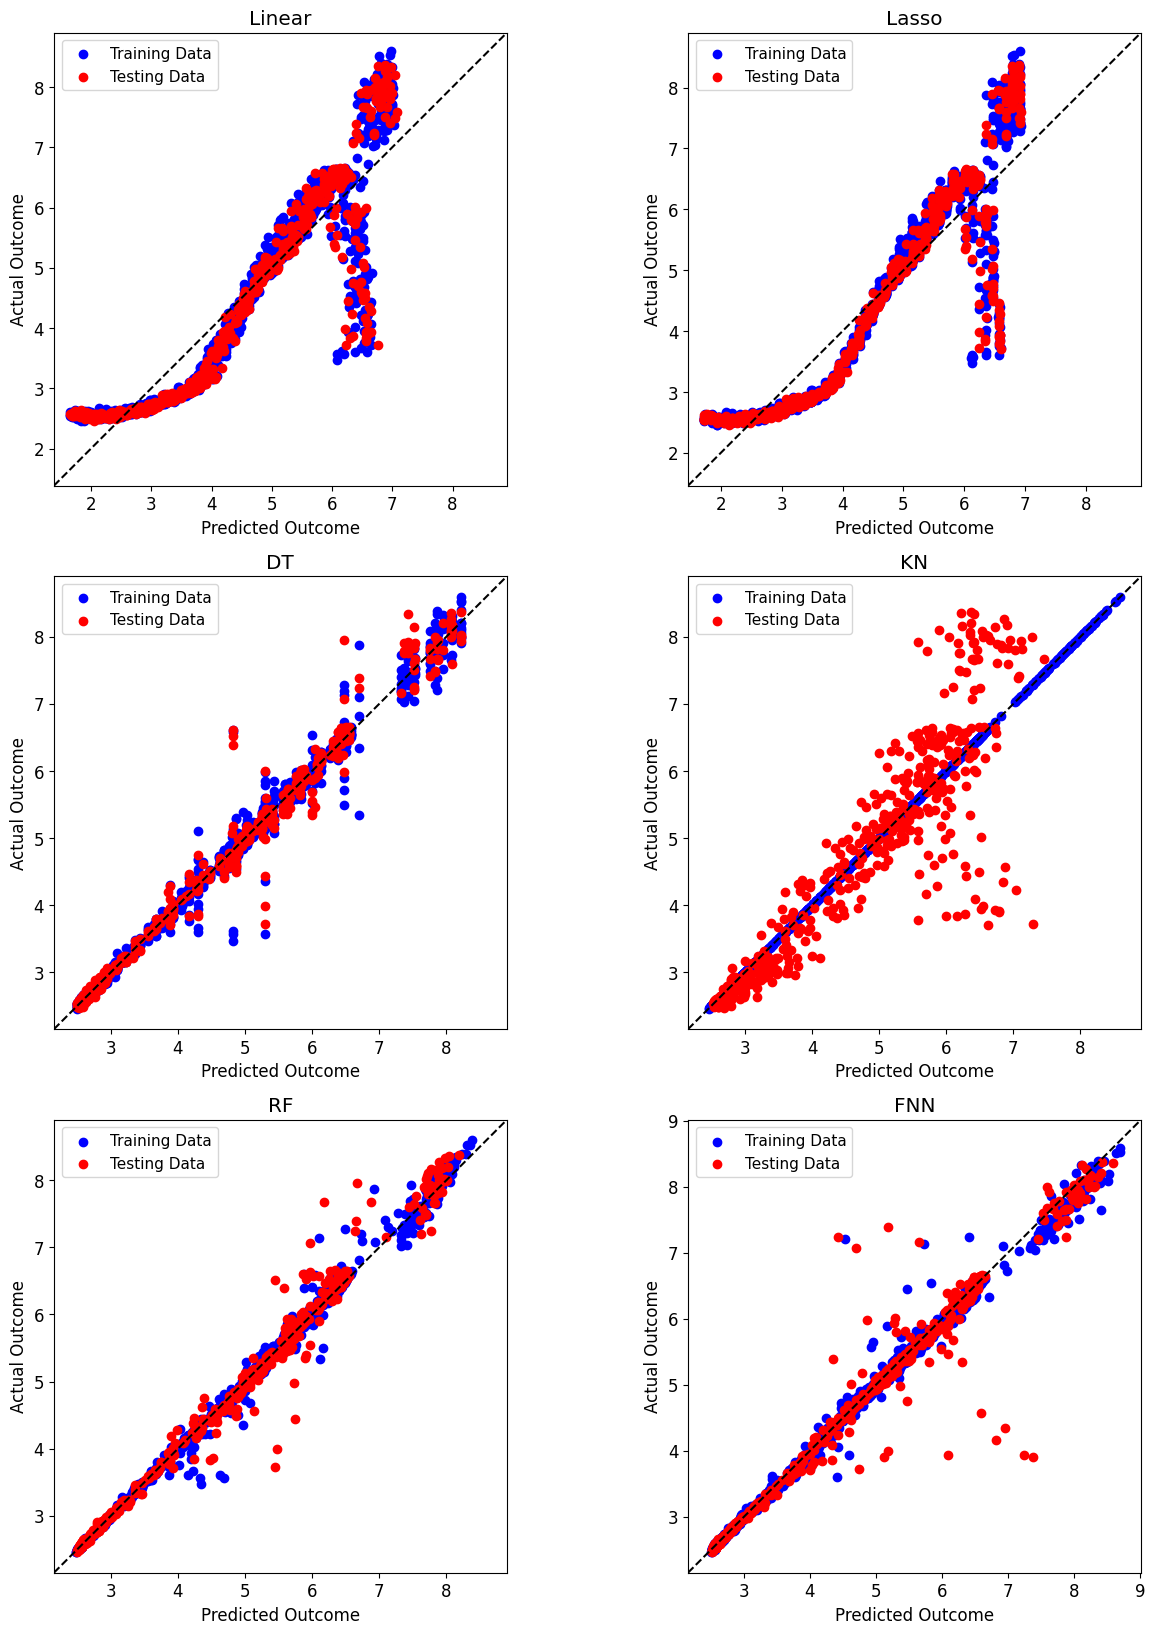

In [20]:
performance_plot(postprocessor.diagonal_validation_plot, "Max4Pin")
plt.show()

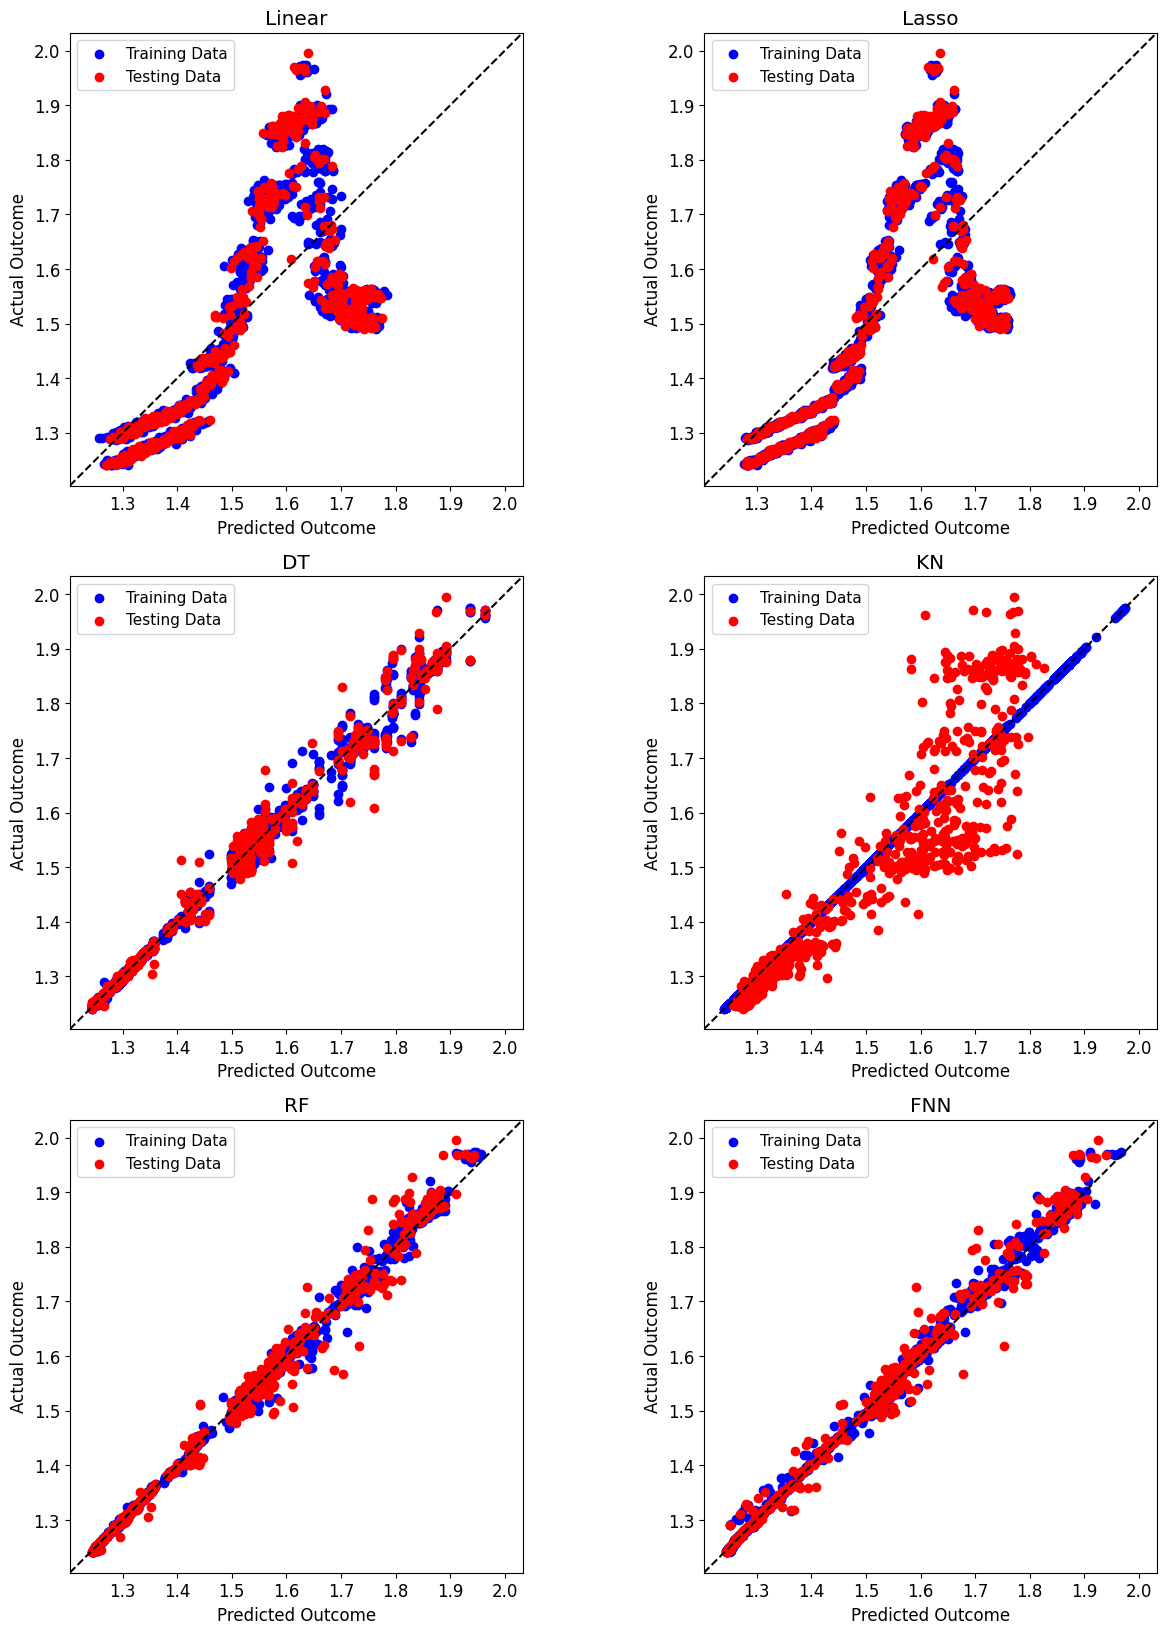

In [21]:
performance_plot(postprocessor.diagonal_validation_plot, "F-delta-H")
plt.show()

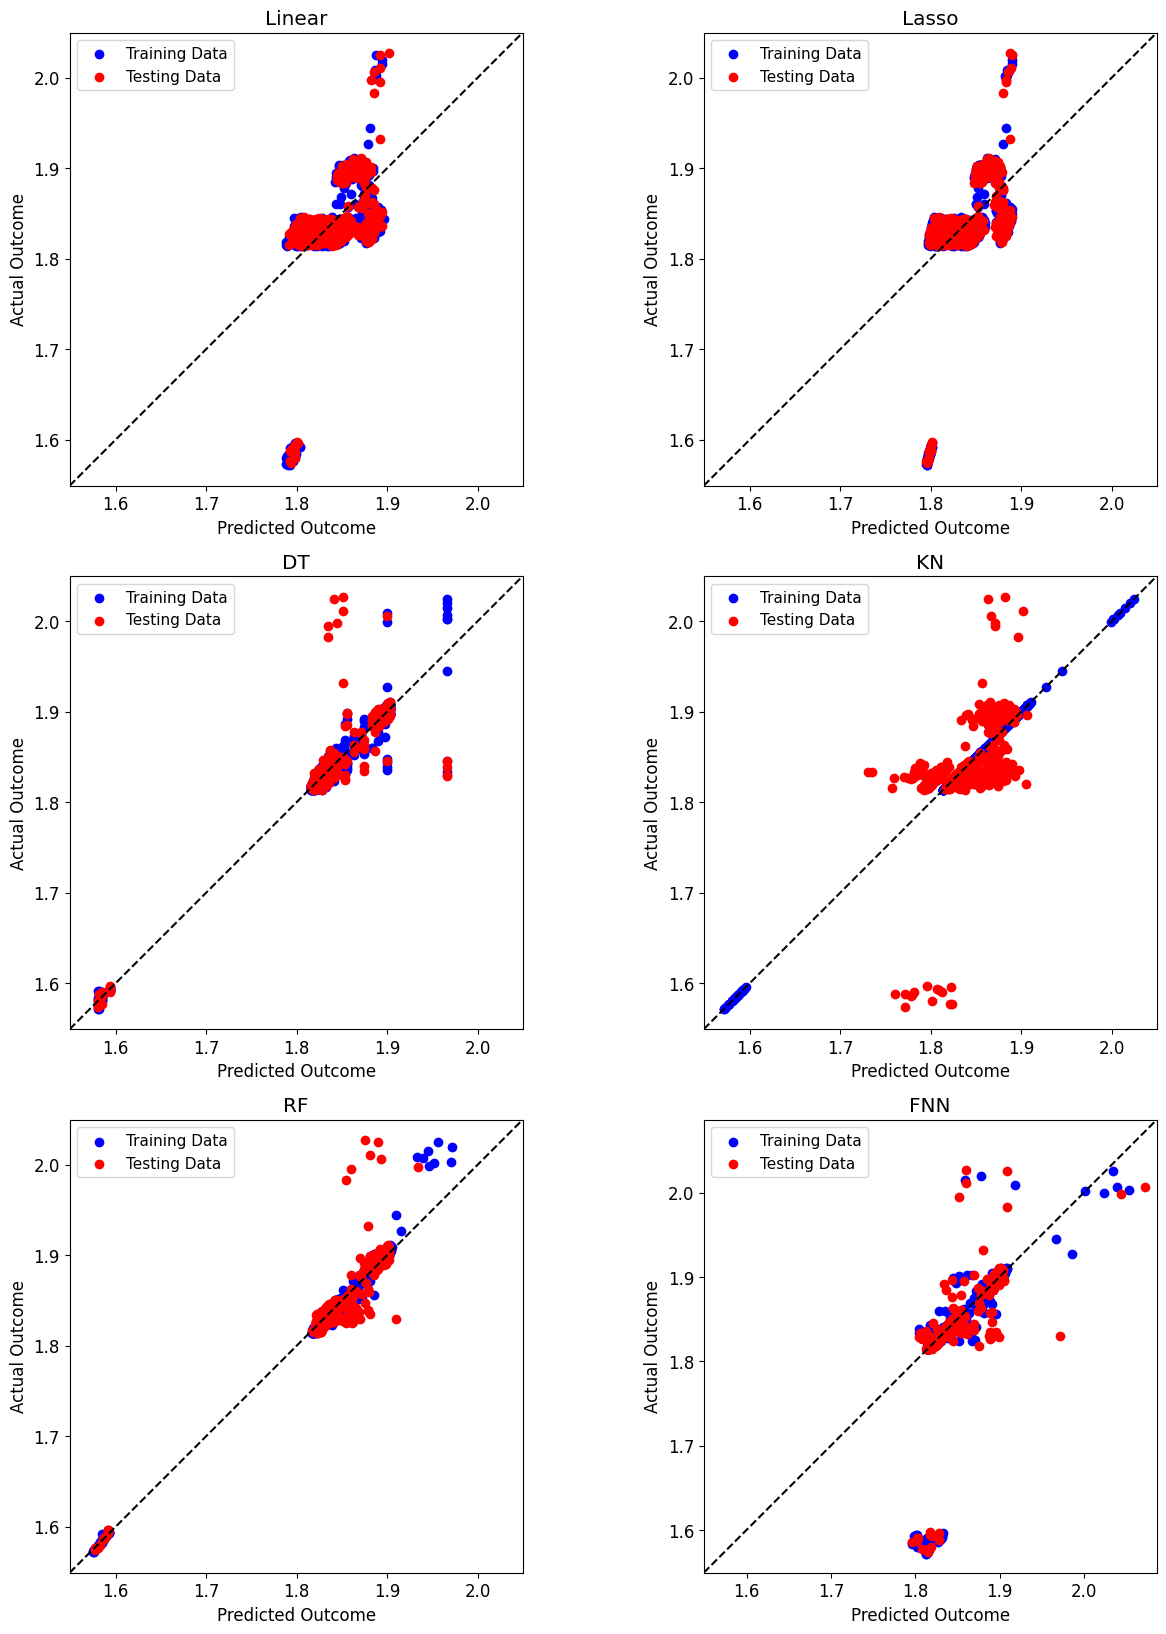

In [22]:
performance_plot(postprocessor.diagonal_validation_plot, "Max-Fxy")
plt.show()

The performance differences between random forest, decision tree, and FNN are minimal except on `Max-Fxy`. For `Max-Fxy`, all models showed considerable spread, with random forest and decision tree showing the tightest spread. In all the distributions, the clear winner is the random forest model. K-nearest neighbors are overfitting to the training data.

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots showing each prediction's absolute relative error.

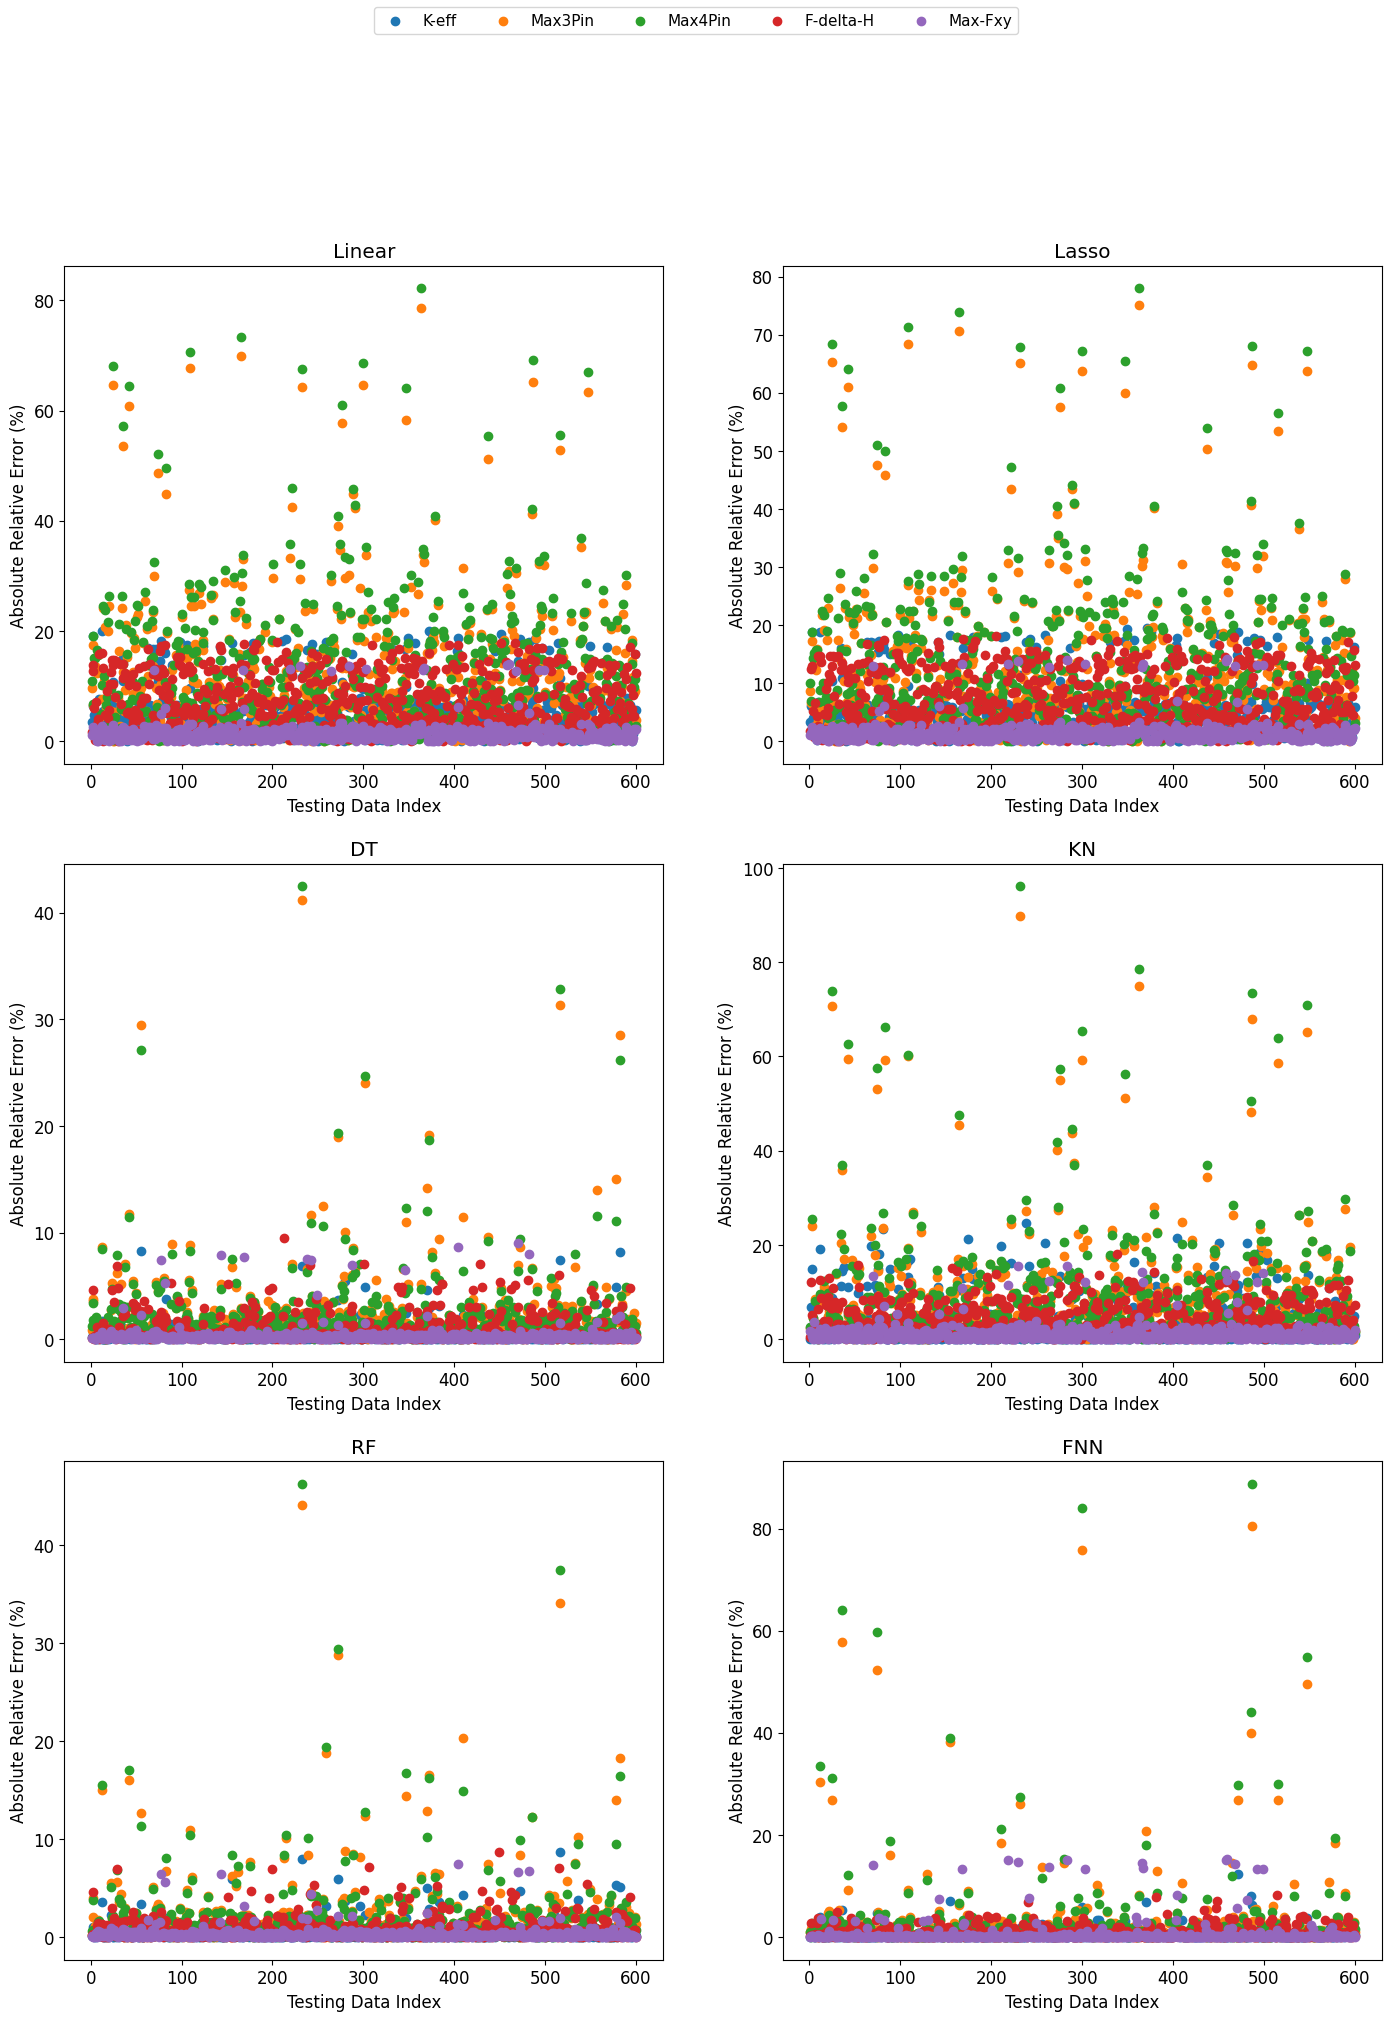

In [23]:
# Output Features and models to plot
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])

# Plot info
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

# Iterate and plot
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(["K-eff", "Max3Pin", "Max4Pin", "F-delta-H", "Max-Fxy"], loc="upper center", ncol=5)
plt.show()

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `RF` and `DT` get as high as $>35\%$ error on `Max3Pin` and `Max4Pin`.

Finally, the learning curve of the most performant FNN is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

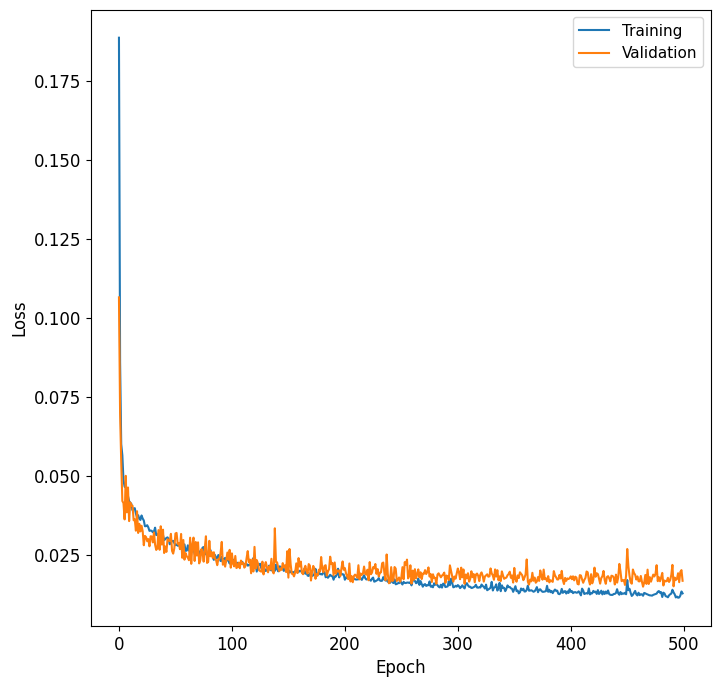

In [24]:
postprocessor.nn_learning_plot()
plt.show()

The FNN is not overfitting with the validation curve below the training curve.

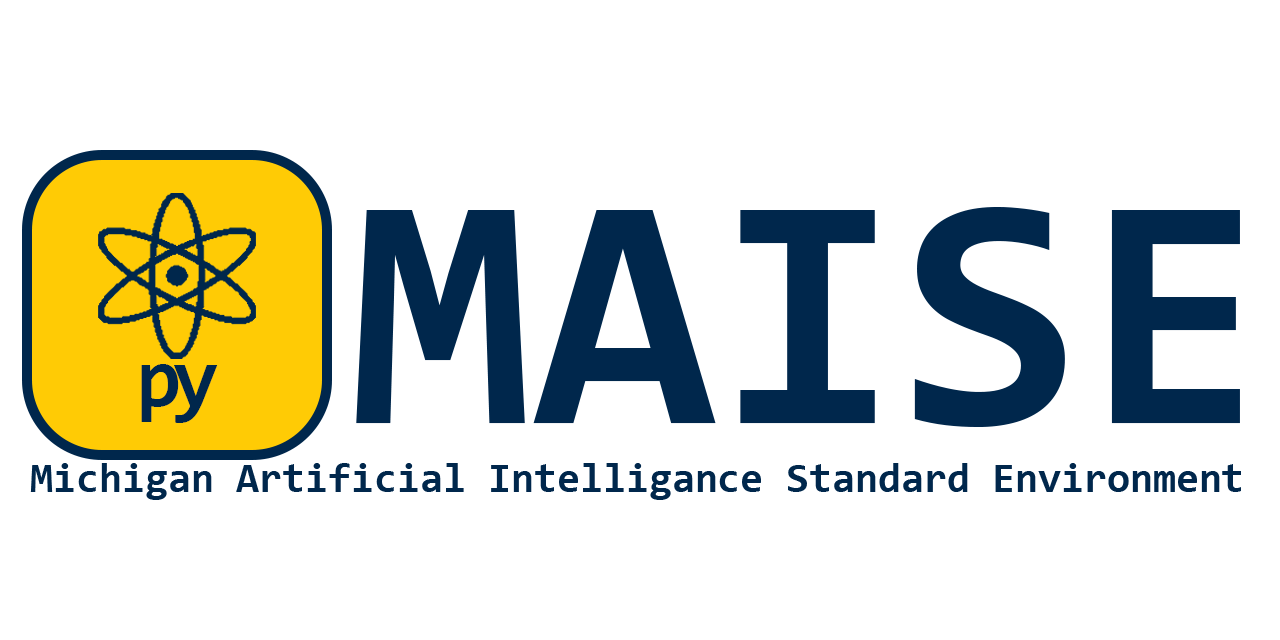